In [1]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam, SGD

C:\Users\KNatarajan\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Real data for training the Discriminator
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

In [3]:
#plot and check
ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [4]:
#Architecture of the Generator
#We create our generative model using simple dense layers activated by tanh. 
#This model will take noise and try to generate sinusoidals from it. 
#This model will not be trained directly but trained via the GAN.
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out


In [5]:
G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Architecture of the Discriminator
#we create our discriminative model that will define if the curve is real or output by the generative model. 
#This one, though will be trained directly.
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='tanh')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out


In [7]:
D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [8]:
#We will need to control when the Discriminator can be trained
# and when it will be frozen
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable


In [9]:
#Build the Chain   (Generator followed by Discriminator)     
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out


In [10]:
GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 50)                12250     
_________________________________________________________________
model_2 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [11]:
#Generate some real and fake data to train the Discriminator
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y


In [12]:
#Input for the Generator
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y


In [13]:
#Train the GAN. First we train the Discriminator.
#Then we freeze the discriminator and train the Generator
def train(GAN, G, D, epochs=100, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=5):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss


Epoch #5: Generative Loss: 1.298345923423767, Discriminative Loss: 0.2252085953950882
Epoch #10: Generative Loss: 2.325531005859375, Discriminative Loss: 0.07435469329357147
Epoch #15: Generative Loss: 3.287560224533081, Discriminative Loss: 0.028980011120438576
Epoch #20: Generative Loss: 3.7806293964385986, Discriminative Loss: 0.01720825582742691
Epoch #25: Generative Loss: 3.810899257659912, Discriminative Loss: 0.016266675665974617
Epoch #30: Generative Loss: 3.4949018955230713, Discriminative Loss: 0.021817434579133987
Epoch #35: Generative Loss: 3.0958926677703857, Discriminative Loss: 0.0331159308552742
Epoch #40: Generative Loss: 2.9664063453674316, Discriminative Loss: 0.04356237128376961
Epoch #45: Generative Loss: 3.322324275970459, Discriminative Loss: 0.04733070358633995
Epoch #50: Generative Loss: 3.2772324085235596, Discriminative Loss: 0.05534816160798073
Epoch #55: Generative Loss: 3.48148512840271, Discriminative Loss: 0.054990254342556
Epoch #60: Generative Loss: 4.

Text(0,0.5,'Loss')

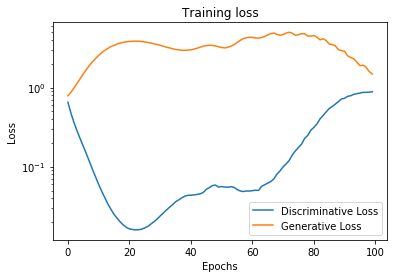

In [14]:
d_loss, g_loss = train(GAN, G, D, verbose=True)

ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")


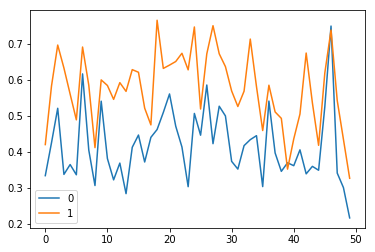

In [15]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

